In [1]:
import os 
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm
from sklearn import datasets as sk_datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

## 1 模型定义

In [2]:
import math
class Bottleneck(nn.Module):
    def __init__(self,in_planes,growth_rate):
        super(Bottleneck,self).__init__()
        self.bn1=nn.BatchNorm2d(in_planes)
        self.conv1=nn.Conv2d(in_planes,4*growth_rate,kernel_size=1,bias=False)
        self.bn2=nn.BatchNorm2d(4*growth_rate)
        self.conv2=nn.Conv2d(4*growth_rate,growth_rate,kernel_size=3,padding=1,bias=False)
        
    def forward(self,x):
        out=self.conv1(F.relu(self.bn1(x)))#pre-activation
        out=self.conv2(F.relu(self.bn2(out)))
        out=torch.cat([out,x],1)
        return out
class Transition(nn.Module):
    def __init__(self,in_planes,out_planes):
        super(Transition,self).__init__()
        self.bn=nn.BatchNorm2d(in_planes)
        self.conv=nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False)
    def forward(self,x):
        out=self.conv(F.relu(self.bn(x)))
        out=F.avg_pool2d(out,2)
        return out
    
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet,self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        self.num_classes = num_classes
        num_planes=2*self.growth_rate #32
        #最初的感知层
        self.conv1=nn.Conv2d(3,num_planes,kernel_size=3,padding=1,bias=False)
        #第一个DenseBlock
        self.dense1=self._make_dense_layers(block,num_planes,nblocks[0])
        num_planes+=nblocks[0]*self.growth_rate
        out_planes=int(math.floor(num_planes*self.reduction))
        self.trans1=Transition(num_planes,out_planes)
        num_planes=out_planes
        #第二个DenseBlock
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*self.growth_rate#计算如果不压缩的话的输出
        out_planes = int(math.floor(num_planes*self.reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第三个DenseBlock
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*self.growth_rate
        out_planes = int(math.floor(num_planes*self.reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第四个DenseBlock
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*self.growth_rate
        #分类层
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes,self.num_classes)
    
    
    def _make_dense_layers(self,block,in_planes,nblock):
        #block:bottleneck
        #nblock代表构建denseblock中有多少bottleneck层
        layers=[]
        for i in range(nblock):
            layers.append(block(in_planes,self.growth_rate))
            in_planes+=self.growth_rate
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out=F.avg_pool2d(F.relu(self.bn(out)),4)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck,[6,12,24,16],growth_rate=32)

## 2 模型训练与评估类

In [3]:
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args,**kwargs)
        end = time.time()
        cost = end - start
        print("Cost time: {} mins.".format(cost/60)) 
    return wrapper

class CNNModel(object):
    def __init__(self, model, train_data, test_data, model_dir, model_name,
                 best_valid_loss=float('inf'), n_split=0.9, batch_size=64, epochs=10):
        self.prediction = []
        self.groundtruth = []
        self.batch_size = batch_size
        self.epochs = epochs
        self.best_valid_loss = best_valid_loss
        self.model_dir = model_dir
        self.model_name = model_name
        self.n_split = n_split
        
        self.train_data =  train_data
        self.test_data = test_data
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.init_data()
        self.init_iterator()
        self.init_model_path()
        
        self.model = self.init_model(model)
        self.optimizer = self.set_optimizer()
        self.criterion = self.set_criterion()
    
    def init_data(self):
        n_train = int(len(self.train_data)*self.n_split)
        n_validation = len(self.train_data) - n_train
        self.train_data, self.valid_data = torch.utils.data.random_split(self.train_data, [n_train, n_validation])
    
    def init_iterator(self):
        self.train_iterator = torch.utils.data.DataLoader(self.train_data, shuffle=True, batch_size=self.batch_size)
        self.valid_iterator = torch.utils.data.DataLoader(self.valid_data, batch_size=self.batch_size)
        self.test_iterator = torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)
        
    def set_optimizer(self):
        optimizer = optim.Adam(self.model.parameters()) 
        return optimizer
    
    def set_criterion(self):
        criterion = nn.CrossEntropyLoss()
        return criterion
    
    def init_model(self, model):
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        model = model.to(self.device)
        return model
        
    def init_model_path(self):
        if not os.path.isdir(self.model_dir):
            os.makedirs(self.model_dir)
        self.model_path = os.path.join(self.model_dir, self.model_name)
        
    # 定义评估函数
    def accu(self, fx, y):
        pred = fx.max(1,keepdim=True)[1]
        correct = pred.eq(y.view_as(pred)).sum()  # 得到该batch的准确度
        acc = correct.float()/pred.shape[0]
        return acc

    def train(self):
        epoch_loss = 0   # 积累变量
        epoch_acc = 0    # 积累变量
        self.model.train()    # 该函数表示PHASE=Train

        for (x,y) in self.train_iterator:  # 拿去每一个minibatch
            x = x.to(self.device)
            y = y.to(self.device)
            self.optimizer.zero_grad()
            fx = self.model(x)           # 进行forward
            loss = self.criterion(fx,y)  # 计算Loss,train_loss
            type(loss)
            acc = self.accu(fx,y)      # 计算精确度，train_accu
            loss.backward()     # 进行BP
            self.optimizer.step()    # 统一更新模型
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss/len(self.train_iterator),epoch_acc/len(self.train_iterator)

    def evaluate(self, iterator, istest=False):
        epoch_loss = 0
        epoch_acc = 0
        self.model.eval()
        with torch.no_grad():
            for (x,y) in iterator:
                x = x.to(self.device)
                y = y.to(self.device)
                fx = self.model(x)
                loss = self.criterion(fx,y)
                if istest:
                    self.prediction.append(fx)
                    self.groundtruth.append(y)
                acc = self.accu(fx,y)
                epoch_loss += loss.item()
                epoch_acc += acc.item()
        return epoch_loss/len(iterator),epoch_acc/len(iterator)
    
    @timer
    def train_fit(self):
        info = 'Epoch:{0} | Train Loss:{1} | Train Acc:{2} | Val Loss:{3} | Val Acc:{4}'
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train()
            valid_loss, valid_acc = self.evaluate(self.valid_iterator, istest=False)
            if valid_loss < self.best_valid_loss:  # 如果是最好的模型就保存到文件夹
                self.best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), self.model_path)
            print(info.format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    
    def get_acc(self):
        self.model.load_state_dict(torch.load(self.model_path))
        test_loss, test_acc = self.evaluate(self.test_iterator, istest=True)
        print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))


## 3 数据集的准备

In [4]:
data_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)) # 参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

data_trans_227 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

data_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

data_test_227 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [5]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=data_trans)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


## 4 模型训练

In [6]:
model_dir = 'models'
best_valid_loss = float('inf')
n_split = 0.9
batch_size = 64
epochs = 1
model_name = "densenet.pt"
model = DenseNet121()

obj = CNNModel(model=model, 
               train_data=train_data, 
               test_data=test_data, 
               model_dir=model_dir, 
               model_name=model_name,
               best_valid_loss=best_valid_loss, 
               n_split=n_split, 
               batch_size=batch_size, 
               epochs=epochs)

In [7]:
print(obj.device)

cuda


In [8]:
print(obj.model)

DataParallel(
  (module): DenseNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dense1): Sequential(
      (0): Bottleneck(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Bottleneck(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): Bottleneck(
        (bn1): BatchNorm2d(12

In [9]:
obj.train_fit()

Epoch:1 | Train Loss:1.4458466593006796 | Train Acc:0.4689053622159091 | Val Loss:1.1311024487773074 | Val Acc:0.5927610759493671
Cost time: 5.100036414464315 mins.


In [10]:
obj.get_acc()

| Test Loss: 1.102382306080715 | Test Acc: 0.6004179936305732 |


In [11]:
model.num_classes

10

## 5 模型评测

In [12]:
def plt_roc(prediction, groundtruth, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # prediction是softmax的前一层结果，cat降维，从GPU到cpu才能转换成np
    pred = torch.cat(prediction).cpu().numpy()   
    gt = torch.cat(groundtruth).cpu().numpy()
    # np.eye()就是拉成one_hot形式
    gt_one_hot = np.eye(num_classes)[gt.reshape(-1)]  # groundtruth的onehot化
    # softmax比叙事tensor格式
    pred_soft = F.softmax(torch.cat(prediction).cpu()).cpu().numpy()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(gt_one_hot[:,i], pred_soft[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    for i in range(num_classes):
        plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
    plt.legend()
    
def plt_pr(prediction, groundtruth, num_classes):
    prc = dict()
    rcl = dict()
    ap = dict()
    pred = torch.cat(prediction).cpu().numpy()
    gt = torch.cat(groundtruth).cpu().numpy()
    gt_one_hot = np.eye(num_classes)[gt.reshape(-1)]  # groundtruth的onehot化
    pred_soft = F.softmax(torch.cat(prediction).cpu()).cpu().numpy()
    for i in range(num_classes):
        prc[i], rcl[i], _ = precision_recall_curve(gt_one_hot[:,i], pred_soft[:,i])
        ap[i] = average_precision_score(gt_one_hot[:,i], pred_soft[:,i])
    for i in range(num_classes):
        plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
    plt.legend()  


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


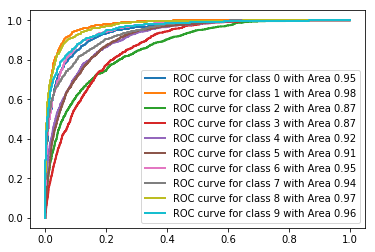

In [13]:
plt_roc(obj.prediction, obj.groundtruth, model.num_classes)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


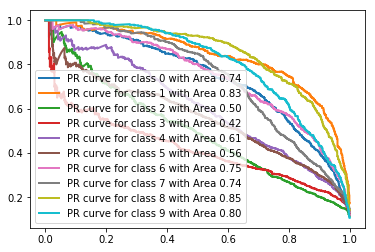

In [14]:
plt_pr(obj.prediction, obj.groundtruth, model.num_classes)